# Pronostic de pannes sur des données IoT

Pronostic de pannes à partir du jeu de données généré par https://github.com/Azure/AI-PredictiveMaintenance/blob/master/src/Notebooks/DataGeneration.ipynb. Proposition de solution à base de machine learning avec un objectif de niveau de confiance élevé.

# 2. Modélisation

In [1]:
# Affichage plus large du notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# Importations de modules et classes
import sys, random, pickle
print("Python: ", sys.version)
import numpy as np
print("NumPy: ", np.__version__)
import joblib
print("Joblib: ", joblib.__version__)
import pandas as pd
print("Pandas: ", pd.__version__)
import sklearn as sk
print("Scikit-learn: ", sk.__version__)
import tensorflow as tf
print("TensorFlow: ", tf.__version__)

from typing import List, Set, Tuple
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from tensorflow import keras
print("Keras: ", keras.__version__)

# Matplotlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
print("Matplotlib: ", matplotlib.__version__)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Python:  3.7.6 (default, Jan 19 2020, 22:34:52) 
[GCC 9.2.1 20200117]
NumPy:  1.18.1
Joblib:  0.14.1
Pandas:  1.0.1
Scikit-learn:  0.22.1
TensorFlow:  2.1.0
Keras:  2.2.4-tf
Matplotlib:  3.1.3


# Chargement des données

Chargement des données qui ont été traitées par le premier notebook `maintenance_1_traitement.ipynb` et écrites dans les fichiers `donnees.parquet` et `mac_panne.pkl`.

In [3]:
%%time
# Chargement des ensembles de machines ayant connu une panne
mac_panne = joblib.load("mac_panne.pkl")
# Chargement des données à partir du fichier .parquet (et mélange des instances)
donnees = pd.read_parquet("donnees.parquet").sample(frac=1).reset_index(drop=True)
# display(donnees.head(1))

CPU times: user 4.89 s, sys: 387 ms, total: 5.28 s
Wall time: 5.55 s


In [4]:
# Récupération du nombre de machines et de l'horizon temporel
n_machines = len(donnees["machineID"].unique())
maxi = donnees["to_F1"].max(axis=0)
print("Nombre de machines: ", n_machines)
print("Durée maximum: ", maxi)

Nombre de machines:  1000
Durée maximum:  6000.0


# Création d'ensembles d'entraînement et de test

In [5]:
def split_train_test(donnees: pd.DataFrame = donnees, mac_panne: [Set[int], Set[int]] = mac_panne, test_ratio: float = .15, seed=None) -> (pd.DataFrame, pd.DataFrame):
    """Création d'ensembles d'entraînement et de test, en sélectionnant des
    machines représentatives quant au type de panne connue (ou d'absence de panne).
    'test_ratio' est la proportion de l'ensemble de test.
    """
    # machines ayant connu une panne de type 1 (resp. 2) et étant dans 'donnees' (précaution nécessaire quand on veut ré-appliquer cette fonction pour créer un ensemble de validation)
    s = [set(donnees["machineID"]) & mac_panne[i] for i in range(2)]
    n_machines = len(donnees["machineID"].unique())
    s.append(set(range(n_machines)) - (s[0] | s[1])) # machines n'ayant pas connu de panne
    random.seed(seed)
    test_set = set.union(*[set(random.sample(s[i], int(len(s[i])*test_ratio))) for i in range(3)])
    print("Nombre de machines en test (sur {} machines): {}.".format(n_machines, len(test_set)))
    donnees_train = donnees[~donnees["machineID"].isin(test_set)]
    donnees_test = donnees[donnees["machineID"].isin(test_set)]
    return donnees_train, donnees_test

In [6]:
donnees_train, donnees_test = split_train_test(donnees, mac_panne, seed=10)
#display(donnees_train.head(1))
#display(donnees_test.head(1))

Nombre de machines en test (sur 1000 machines): 149.


# Classification par type de panne

Commençons par prédire le "type de la prochaine" panne. Comme visualisé, les deux classes sont affinement séparables, donc on utilise une régression logistique élémentaire, et après validation croisée, on teste sur l'ensemble de teste et on obtient de bonnes prédictions.

In [7]:
def separe_target_classif(donnees: pd.DataFrame) -> (pd.DataFrame, pd.Series):
    df = donnees.copy()
    df.drop(df[df["type"] == 0.5].index, inplace=True)
    target = df["type"].copy()
    df.drop(["seconds_ON", "seconds", "machineID", "from_fix", "to_break", "to_F1", "to_F2", "type"], axis=1, inplace=True)
    return df, target

In [8]:
donnees_train_cl_sans, donnees_train_cl_target = separe_target_classif(donnees_train)
donnees_test_cl_sans, donnees_test_cl_target = separe_target_classif(donnees_test)

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
logreg1 = LogisticRegression(solver="sag", verbose=3, n_jobs=-1) # "sag" rapide si beaucoup d'instances

In [11]:
from sklearn.model_selection import cross_val_predict

In [12]:
%%time
donnees_train_cl_predict = cross_val_predict(logreg1, donnees_train_cl_sans, donnees_train_cl_target, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


CPU times: user 1.2 s, sys: 1.2 s, total: 2.4 s
Wall time: 16.2 s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished


In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
confusion_matrix(donnees_train_cl_target, donnees_train_cl_predict)

array([[975978,      0],
       [     0, 384054]])

In [15]:
%%time
logreg1.fit(donnees_train_cl_sans, donnees_train_cl_target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.


convergence after 11 epochs took 4 seconds
CPU times: user 3.98 s, sys: 13.9 ms, total: 3.99 s
Wall time: 4.08 s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=3,
                   warm_start=False)

In [16]:
print(logreg1.classes_)
print(logreg1.coef_)
print(logreg1.intercept_)
print(logreg1.n_iter_)
# Comme visualisé, c'est bien la pression qui est l'indicateur principal, et les signes des coefficients sont bien cohérents

[0. 1.]
[[-17.62657393  82.33367484  44.51140775]]
[-61.17296485]
[11]


In [17]:
confusion_matrix(donnees_test_cl_target, logreg1.predict(donnees_test_cl_sans))

array([[169643,      0],
       [  1442,  61312]])

In [18]:
from sklearn.metrics import f1_score

In [19]:
f1_score(donnees_test_cl_target, logreg1.predict(donnees_test_cl_sans))

0.9883771540954008

### Classification régularisée

In [20]:
from sklearn.model_selection import GridSearchCV
logreg2 = LogisticRegression(solver="sag", verbose=3, n_jobs=-1)
param_grid = [{"C": [1, 3, 9]}]
logreg2_grid_search = GridSearchCV(logreg2, param_grid, cv=12, scoring="f1", return_train_score=True, refit=True, verbose=3, n_jobs=-1)

In [21]:
%%time
logreg2_grid_search.fit(donnees_train_cl_sans, donnees_train_cl_target)

Fitting 12 folds for each of 3 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.


convergence after 11 epochs took 4 seconds
CPU times: user 4.33 s, sys: 227 ms, total: 4.55 s
Wall time: 1min 29s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s finished


GridSearchCV(cv=12, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=None, solver='sag',
                                          tol=0.0001, verbose=3,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1, param_grid=[{'C': [1, 3, 9]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1', verbose=3)

In [22]:
cvres = logreg2_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, "  ", params)
print("Meilleurs paramètres: ", logreg2_grid_search.best_params_)

1.0    {'C': 1}
1.0    {'C': 3}
1.0    {'C': 9}
Meilleurs paramètres:  {'C': 1}


In [23]:
confusion_matrix(donnees_train_cl_target, logreg2_grid_search.predict(donnees_train_cl_sans))

array([[975978,      0],
       [     0, 384054]])

In [24]:
confusion_matrix(donnees_test_cl_target, logreg2_grid_search.predict(donnees_test_cl_sans))

array([[169643,      0],
       [  1477,  61277]])

In [25]:
f1_score(donnees_test_cl_target, logreg2_grid_search.predict(donnees_test_cl_sans))

0.9880916867557304

In [26]:
logreg3 = LogisticRegression(C=10, solver="sag", verbose=3, n_jobs=-1)
logreg3.fit(donnees_train_cl_sans, donnees_train_cl_target)
print(confusion_matrix(donnees_train_cl_target, logreg3.predict(donnees_train_cl_sans)))
donnees_test_cl_predict = logreg3.predict(donnees_test_cl_sans)
print(confusion_matrix(donnees_test_cl_target, donnees_test_cl_predict))
print("f1 score: ", f1_score(donnees_test_cl_target, donnees_test_cl_predict))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.


convergence after 59 epochs took 21 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.9s finished


[[975978      0]
 [     0 384054]]
[[169643      0]
 [   959  61795]]
f1 score:  0.9923002191908407


# Modèles

Puisque le type de la prochaine panne est bien prédictible, il reste à prédire les temps-avant-panne. Etant donné les surfaces visualisées à la fin de `maintenance_1_traitement.ipynb`, on voit qu'une approximation sera difficile, et qu'il apparaît plus facile de traiter les deux types de panne séparément. En phase de production, on passera d'abord les données au classificateur, puis en fonction du résultat, à l'estimateur pour les pannes F1 ou à l'estimateur pour les pannes F2.

On commence par la panne F1 et plusieurs régressions polynomiales. Puis on entraîne un arbre de décision classique (`tree1`). On voit par validation croisée qu'il suradapte, donc on contraint le modèle et considère un arbre à profondeur limitée (`tree2`).

On regarde ensuite une forêt aléatoire (`forest1`), qui suradapte mais semble meilleure. Pour trouver de bons hyperparamètres, on fait une "validation croisée par recherche en grille" (`forest2`). L'intervalle de confiance à 95% pour l'erreur-type de ce dernier modèle est [18.5, 24] secondes. On représente graphiquement les prédictions. Une recherche plus fine permettrait de repérer où les erreurs les plus importantes se concentrent (probablement pour des cibles entre 4000 et 6000 secondes, étant donné les pentes des surfaces graphées).

Pour la panne F2, on considère directement une forêt aléatoire dont on ajuste les hyperparamètres par validation croisée par recherche en grille.

On pourrait aussi essayer un SVM avec un noyau non-linéaire.

Ces modèles ne considèrent pas les "historiques" (à part dans le prétraitement par le calcul des moyennes), donc considèrent chaque donnée comme une instance indépendante, et non comme un point dans une série temporelle. Il me semble qu'il y aurait peu d'informations à gagner en considérant ces séries (par exemple avec des RNN ou des cellules LSTM). On pourrait peut être creuser la piste des dérivées (en prenant les différences sur des temps plus longs), et considérer ces temps, ainsi que les temps de moyennage, comme des hyperparamètres à ajuster (pour cela, il faut faire des fonctions de moyennage et de calcul de dérivée ci-dessus des Transformers de sklearn, ce qui permet de mettre les paramètres dans une `param_grid`).

Remarque: tous les entraînements ont été faits avec comme score l'erreur quadratique moyenne des temps-avant-panne. D'autres métriques sont possibles (pour refléter le fait que se tromper de 5 minutes pour une panne dans une heure est moins grave que se tromper de 30 secondes pour une panne dans 30 secondes). Selon l'objectif final du client, on pourra aussi considérer par exemple des étiquettes avec trois valeurs: panne dans les 10 prochaines minutes | panne dans les 3 prochaines heures | pas de panne prochaine. On pourrait aussi "clipper" les prédictions à `maxi` pour ne pas pénaliser un système qui "prolonge les surfaces" visualisées sur les graphes 3D (ce que l'on fait pour les régressions polynomiales ci-dessous).

## Séparation des données par type de panne

In [27]:
# Il semble plus pratique de séparer les données pour chaque code de panne, car beaucoup de méthodes de
# scikit-learn n'acceptent pas de targets "nan".
def donnees_par_code(donnees: pd.DataFrame = donnees) -> [pd.DataFrame, pd.DataFrame]:
    return [donnees.dropna(subset=["to_F"+str(i+1)]).drop(["to_F"+str(2-i)], axis=1) for i in range(2)]

In [28]:
donnees_train_code = donnees_par_code(donnees_train)
donnees_test_code = donnees_par_code(donnees_test)
#for i in range(2):
#    display(donnees_train_code[i].head(5))
#    display(donnees_test_code[i].head(5))

In [29]:
for i in range(2):
    print("Pour la panne F{}: {:_} données d'entraînement et {:_} données de test.".format(i+1, donnees_train_code[i].shape[0], donnees_test_code[i].shape[0]))

Pour la panne F1: 5_043_732 données d'entraînement et 839_321 données de test.
Pour la panne F2: 4_451_808 données d'entraînement et 732_432 données de test.


In [30]:
# Mise en forme pour le ML: séparation des données sans cible et des cibles.
def separe_target(donnees_xxx_code: [pd.DataFrame, pd.DataFrame]) -> ([pd.DataFrame, pd.DataFrame], [pd.Series, pd.Series]):
    donnees_xxx_sans = [0, 0]
    donnees_xxx_target = [0, 0]
    for i in range(2):
        donnees_xxx_sans[i] = donnees_xxx_code[i].drop(["seconds_ON", "seconds", "machineID", "from_fix", "to_break", "to_F"+str(i+1)], axis=1)
        donnees_xxx_target[i] = donnees_xxx_code[i]["to_F"+str(i+1)].copy()
    return donnees_xxx_sans, donnees_xxx_target

In [31]:
donnees_train_sans, donnees_train_target = separe_target(donnees_train_code)
donnees_test_sans, donnees_test_target = separe_target(donnees_test_code)
#display(donnees_train_sans[0].values)
#display(donnees_train_target[0].values) # pd.Series

In [32]:
# Premier choix de métrique: erreur quadratique moyenne
from sklearn.metrics import mean_squared_error
# Validation croisée
from sklearn.model_selection import cross_val_score

In [33]:
def affiche_scores(scores):
    """Affichage de la moyenne et de l'écart-type des erreur
    lors d'une validation croisée.
    """
    print("Validation croisée:")
    #print("Scores: ", scores)
    print("Moyenne: ", scores.mean())
    print("Ecart-type: ", scores.std())

## Machine à vecteurs de support (fausse piste)

Pour des régressions non linéaires, les algorithmes pour SVM sont au mieux quadratiques en le nombre d'instances, donc pas praticables ici (5 millions d'instances).

In [34]:
%%time
from sklearn import svm
# Les données ne sont évidemment pas linéaires; ceci est seulement un test.
svm1 = svm.LinearSVR(C=1, verbose=3, max_iter=10)
svm1.fit(donnees_train_sans[0].values, donnees_train_target[0].values)
print("Erreur-type après adapation à l'ensemble d'entraînement: ",
      np.sqrt(mean_squared_error(donnees_train_target[0], svm1.predict(donnees_train_sans[0]))))

[LibLinear]Erreur-type après adapation à l'ensemble d'entraînement:  736.4735157287132
CPU times: user 6.95 s, sys: 117 ms, total: 7.07 s
Wall time: 6.92 s


/home/benoit/Documents/_programmation/_python/sopra/sopraenv/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Régression SGD

Essai de régression polynomiale (entraînement par descente de gradient stochastique).

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor

In [36]:
poly_feat = PolynomialFeatures(degree=7, include_bias=False)

In [37]:
donnees_train_sans_poly = poly_feat.fit_transform(donnees_train_sans[0])
donnees_test_sans_poly = poly_feat.fit_transform(donnees_test_sans[0])

In [93]:
sgd1 = SGDRegressor(loss="squared_loss", early_stopping=True, validation_fraction=0.1, tol=1e-3, n_iter_no_change=5, verbose=3)

In [237]:
%%time
sgd1.fit(donnees_train_sans_poly, donnees_train_target[0].values)

-- Epoch 1
Norm: 9862.03, NNZs: 329, Bias: 3164.386336, T: 4539358, Avg. loss: 92237.193144
Total training time: 42.08 seconds.
-- Epoch 2
Norm: 11711.51, NNZs: 329, Bias: 3217.738098, T: 9078716, Avg. loss: 71342.608189
Total training time: 48.11 seconds.
-- Epoch 3
Norm: 13246.84, NNZs: 329, Bias: 3300.709013, T: 13618074, Avg. loss: 63166.056412
Total training time: 53.57 seconds.
-- Epoch 4
Norm: 14516.67, NNZs: 329, Bias: 3393.094598, T: 18157432, Avg. loss: 57520.145231
Total training time: 59.05 seconds.
-- Epoch 5
Norm: 15568.35, NNZs: 329, Bias: 3479.027901, T: 22696790, Avg. loss: 53350.093530
Total training time: 64.53 seconds.
-- Epoch 6
Norm: 16449.58, NNZs: 329, Bias: 3557.258467, T: 27236148, Avg. loss: 50153.164436
Total training time: 70.00 seconds.
Convergence after 6 epochs took 71.19 seconds
CPU times: user 1min, sys: 14.4 s, total: 1min 14s
Wall time: 1min 22s


SGDRegressor(alpha=0.0001, average=False, early_stopping=True, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=3,
             warm_start=False)

In [238]:
print("Erreur-type après adapation à l'ensemble d'entraînement: ",
      np.sqrt(mean_squared_error(donnees_train_target[0].values, sgd1.predict(donnees_train_sans_poly))))

Erreur-type après adapation à l'ensemble d'entraînement:  329.29669624732156


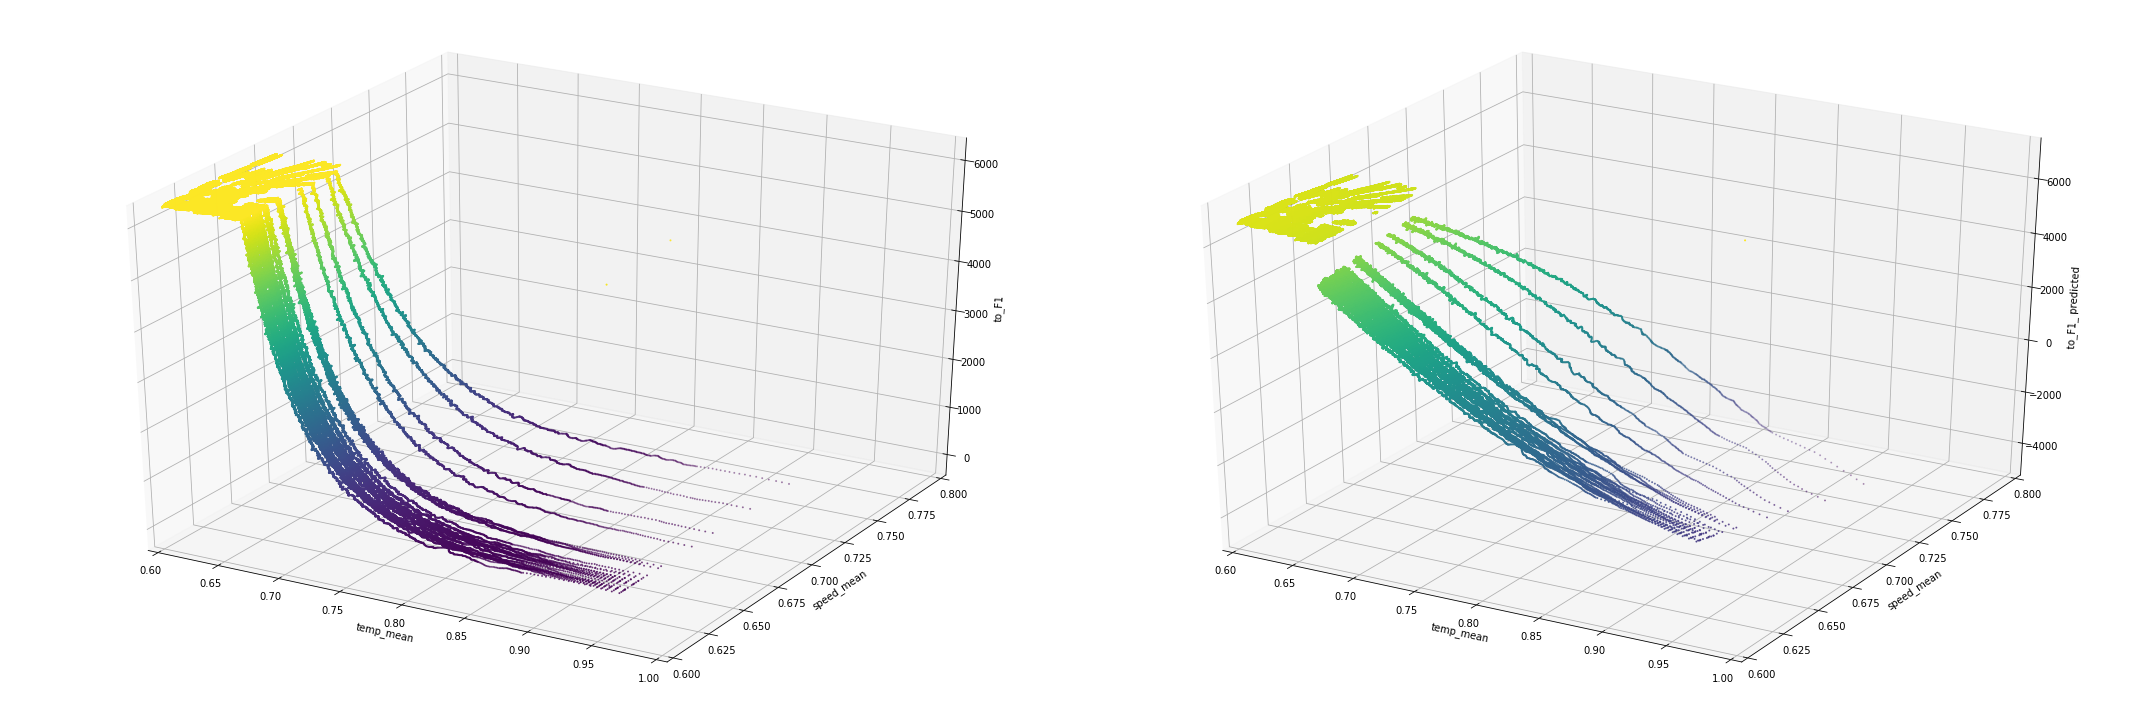

CPU times: user 31.5 s, sys: 2.81 s, total: 34.3 s
Wall time: 31.9 s


In [239]:
%%time
# Comparaison des prévisions pour les pannes F1.
# On ne représente que donnees_test pour des raisons de temps de calcul
df = donnees_test_code[0]
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
z = df["to_F1"]
ax.scatter(xs=df["temp_mean"], ys=df["speed_mean"], zs=z, s=1, c=z)
ax.set_xlim([.6, 1])
ax.set_ylim([.6, .8])
ax.set_xlabel('temp_mean')
ax.set_ylabel('speed_mean')
ax.set_zlabel('to_F1')

ax = fig.add_subplot(1, 2, 2, projection='3d')
z = sgd1.predict(donnees_test_sans_poly)
ax.scatter(xs=df["temp_mean"], ys=df["speed_mean"], zs=z, s=1, c=z)
ax.set_xlim([.6, 1])
ax.set_ylim([.6, .8])
ax.set_xlabel('temp_mean')
ax.set_ylabel('speed_mean')
ax.set_zlabel('to_F1_ predicted')
plt.tight_layout()
plt.show()

C'est la présence du "plateau" qui empêche une bonne approximation polynomiale. On peut donc entraîner le SGD sur les instances avec `"to_break" < maxi`, puis prendre le min de la prédiction et de `maxi`.

In [38]:
donnees_train_maxi = donnees_train.drop(donnees_train[donnees_train["to_break"] == maxi].index)
donnees_train_code_maxi = donnees_par_code(donnees_train_maxi)
donnees_train_sans_maxi, donnees_train_target_maxi = separe_target(donnees_train_code_maxi)
donnees_train_sans_maxi_poly = poly_feat.fit_transform(donnees_train_sans_maxi[0])
# donnees_test_maxi = donnees_test.drop(donnees_test[donnees_test["to_break"] == maxi].index)
# donnees_test_code_maxi = donnees_par_code(donnees_test_maxi)
# donnees_test_sans_maxi, donnees_test_target_maxi = separe_target(donnees_test_code_maxi)
# donnees_test_sans_maxi_poly = poly_feat.fit_transform(donnees_test_sans_maxi[0])

In [241]:
sgd2 = SGDRegressor(loss="squared_loss", early_stopping=True, validation_fraction=0.1, tol=1e-7, n_iter_no_change=10, verbose=3)

In [242]:
%%time
sgd2.fit(donnees_train_sans_maxi_poly, donnees_train_target_maxi[0].values)

-- Epoch 1
Norm: 11000.37, NNZs: 119, Bias: 2551.535353, T: 878380, Avg. loss: 291984.383661
Total training time: 0.77 seconds.
-- Epoch 2
Norm: 14297.07, NNZs: 119, Bias: 2801.395868, T: 1756760, Avg. loss: 182942.122599
Total training time: 1.77 seconds.
-- Epoch 3
Norm: 16561.11, NNZs: 119, Bias: 2933.015372, T: 2635140, Avg. loss: 141614.273574
Total training time: 2.76 seconds.
-- Epoch 4
Norm: 18204.05, NNZs: 119, Bias: 3029.294443, T: 3513520, Avg. loss: 119642.929641
Total training time: 3.77 seconds.
-- Epoch 5
Norm: 19412.11, NNZs: 119, Bias: 3121.608321, T: 4391900, Avg. loss: 106763.357394
Total training time: 4.81 seconds.
-- Epoch 6
Norm: 20330.77, NNZs: 119, Bias: 3190.014387, T: 5270280, Avg. loss: 98710.089412
Total training time: 5.81 seconds.
-- Epoch 7
Norm: 21035.94, NNZs: 119, Bias: 3253.677582, T: 6148660, Avg. loss: 93411.241447
Total training time: 6.80 seconds.
-- Epoch 8
Norm: 21589.71, NNZs: 119, Bias: 3321.340263, T: 7027040, Avg. loss: 89772.593235
Total t

SGDRegressor(alpha=0.0001, average=False, early_stopping=True, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=10, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=1e-07, validation_fraction=0.1, verbose=3,
             warm_start=False)

In [243]:
print("Erreur-type après adapation à l'ensemble d'entraînement: ",
      np.sqrt(mean_squared_error(donnees_train_target[0].values, np.clip(sgd2.predict(donnees_train_sans_poly), a_min=0, a_max=maxi))))

Erreur-type après adapation à l'ensemble d'entraînement:  203.3169408289432


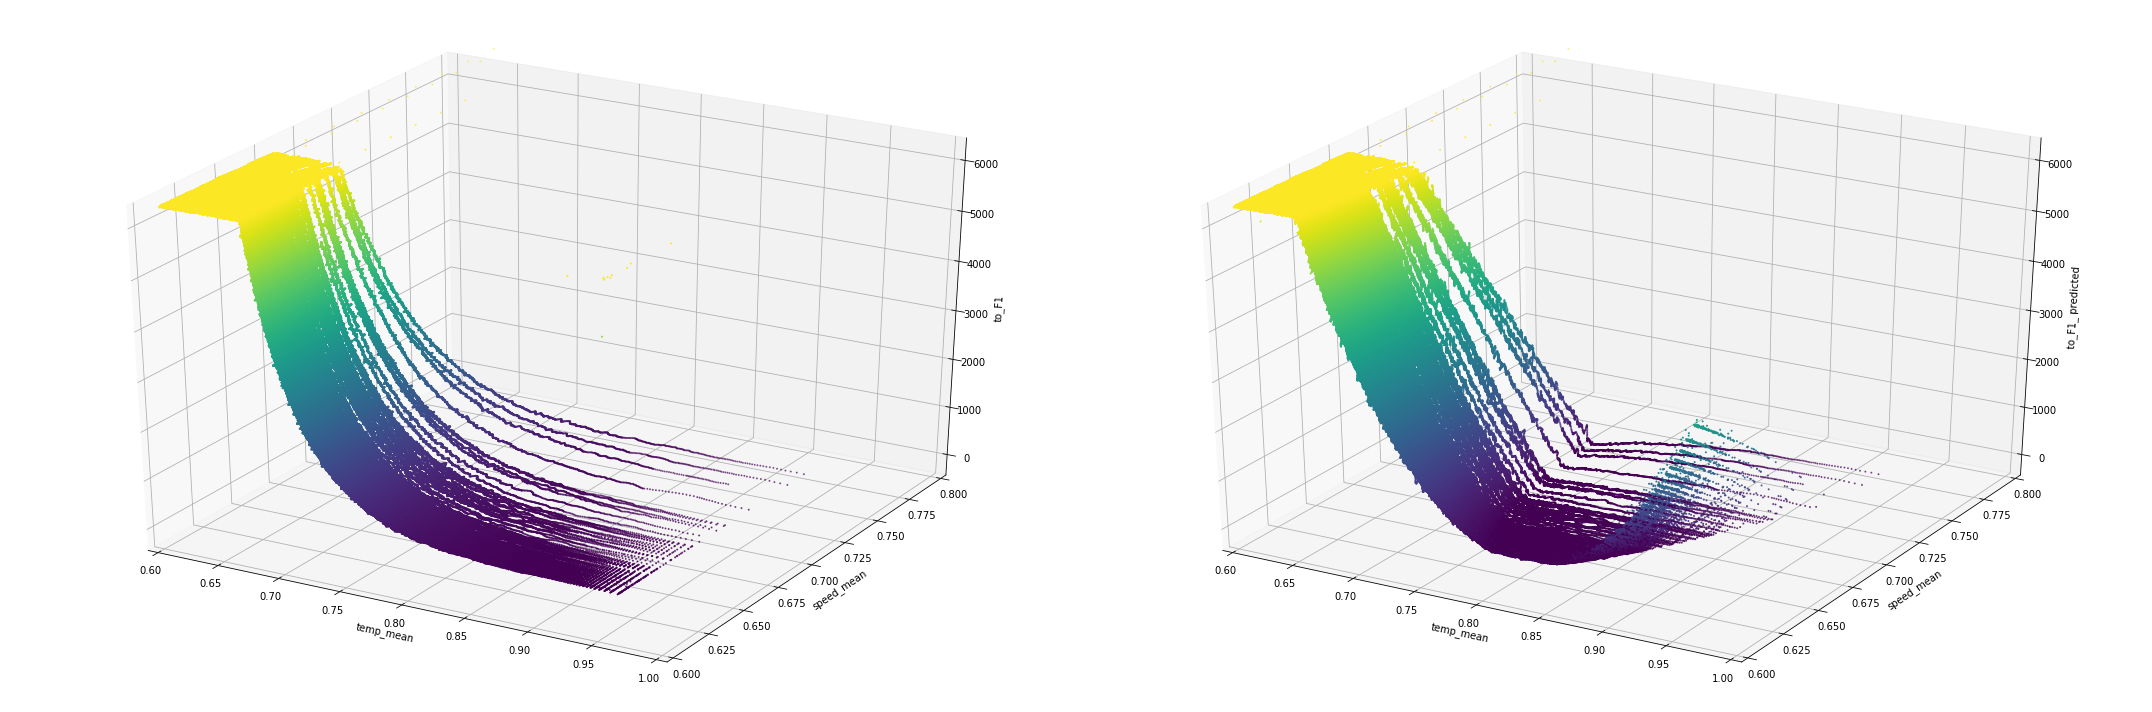

CPU times: user 2min 58s, sys: 2.98 s, total: 3min 1s
Wall time: 2min 56s


In [245]:
%%time
df = donnees_train_code[0]
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
z = df["to_F1"]
ax.scatter(xs=df["temp_mean"], ys=df["speed_mean"], zs=z, s=1, c=z)
ax.set_xlim([.6, 1])
ax.set_ylim([.6, .8])
ax.set_xlabel('temp_mean')
ax.set_ylabel('speed_mean')
ax.set_zlabel('to_F1')

ax = fig.add_subplot(1, 2, 2, projection='3d')
z = np.clip(sgd2.predict(donnees_train_sans_poly), a_min=0, a_max=maxi)
ax.scatter(xs=df["temp_mean"], ys=df["speed_mean"], zs=z, s=1, c=z)
ax.set_xlim([.6, 1])
ax.set_ylim([.6, .8])
ax.set_xlabel('temp_mean')
ax.set_ylabel('speed_mean')
ax.set_zlabel('to_F1_ predicted')
plt.tight_layout()
plt.show()

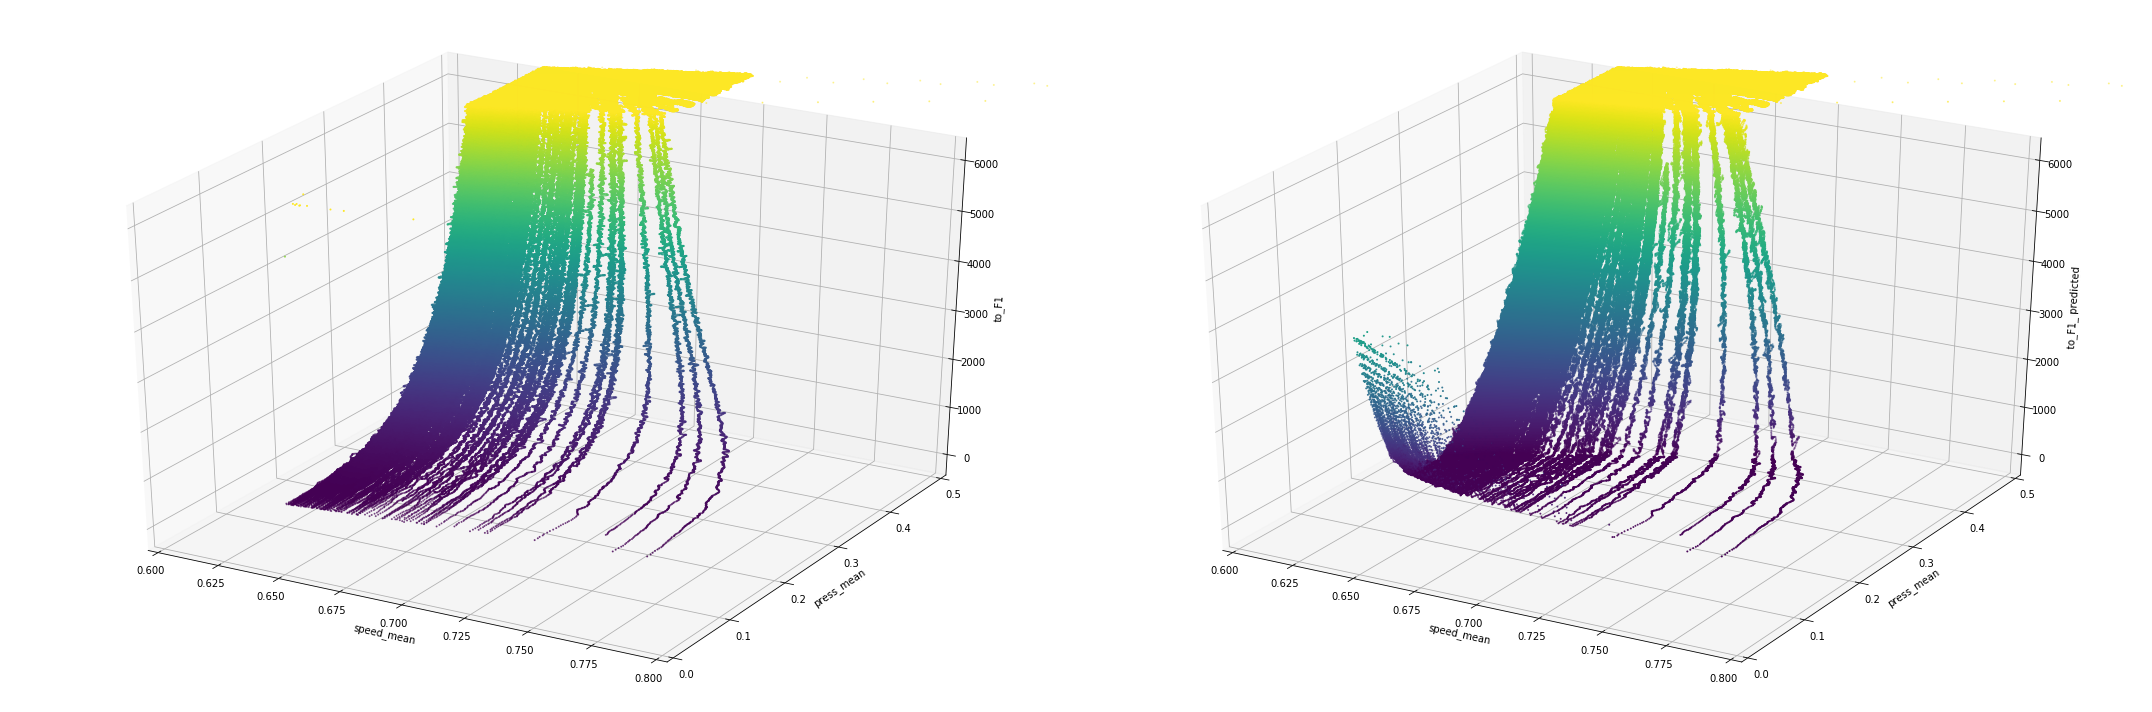

CPU times: user 3min, sys: 3.04 s, total: 3min 3s
Wall time: 2min 57s


In [246]:
%%time
df = donnees_train_code[0]
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
z = df["to_F1"]
ax.scatter(xs=df["speed_mean"], ys=df["press_mean"], zs=z, s=1, c=z)
ax.set_xlim([.6, .8])
ax.set_ylim([0, .5])
ax.set_xlabel('speed_mean')
ax.set_ylabel('press_mean')
ax.set_zlabel('to_F1')

ax = fig.add_subplot(1, 2, 2, projection='3d')
z = np.clip(sgd2.predict(donnees_train_sans_poly), a_min=0, a_max=maxi)
ax.scatter(xs=df["speed_mean"], ys=df["press_mean"], zs=z, s=1, c=z)
ax.set_xlim([.6, .8])
ax.set_ylim([0, .5])
ax.set_xlabel('speed_mean')
ax.set_ylabel('press_mean')
ax.set_zlabel('to_F1_ predicted')
plt.tight_layout()
plt.show()

C'est encore le "plateau" aux temps très proches des pannes, qui empêche l'approximation polynomiale. On pourrait donc entraîner le régresseur sur les instances avec `to_F1 > 10` et prendre comme prédiction le max de la prédiction et de 10 (en comptant une prédiction de 10 quand la vraie cible est inférieure à 10, comme correcte).

## Régression polynomiale régularisée (crête)

In [39]:
from sklearn.linear_model import RidgeCV

In [40]:
ridge1 = RidgeCV(alphas=(1e-8, 2e-8, 4e-8), normalize=True, cv=9)

In [41]:
%%time
ridge1.fit(donnees_train_sans_maxi_poly, donnees_train_target_maxi[0].values)

CPU times: user 2min 38s, sys: 1min 5s, total: 3min 44s
Wall time: 1min 41s


RidgeCV(alphas=array([1.e-08, 2.e-08, 4.e-08]), cv=9, fit_intercept=True,
        gcv_mode=None, normalize=True, scoring=None, store_cv_values=False)

In [43]:
print(ridge1.alpha_)

1e-08


In [44]:
print("Erreur-type après adapation à l'ensemble d'entraînement: ",
      np.sqrt(mean_squared_error(donnees_train_target[0].values, np.clip(ridge1.predict(donnees_train_sans_poly), a_min=0, a_max=maxi))))

Erreur-type après adapation à l'ensemble d'entraînement:  21.893991364798975


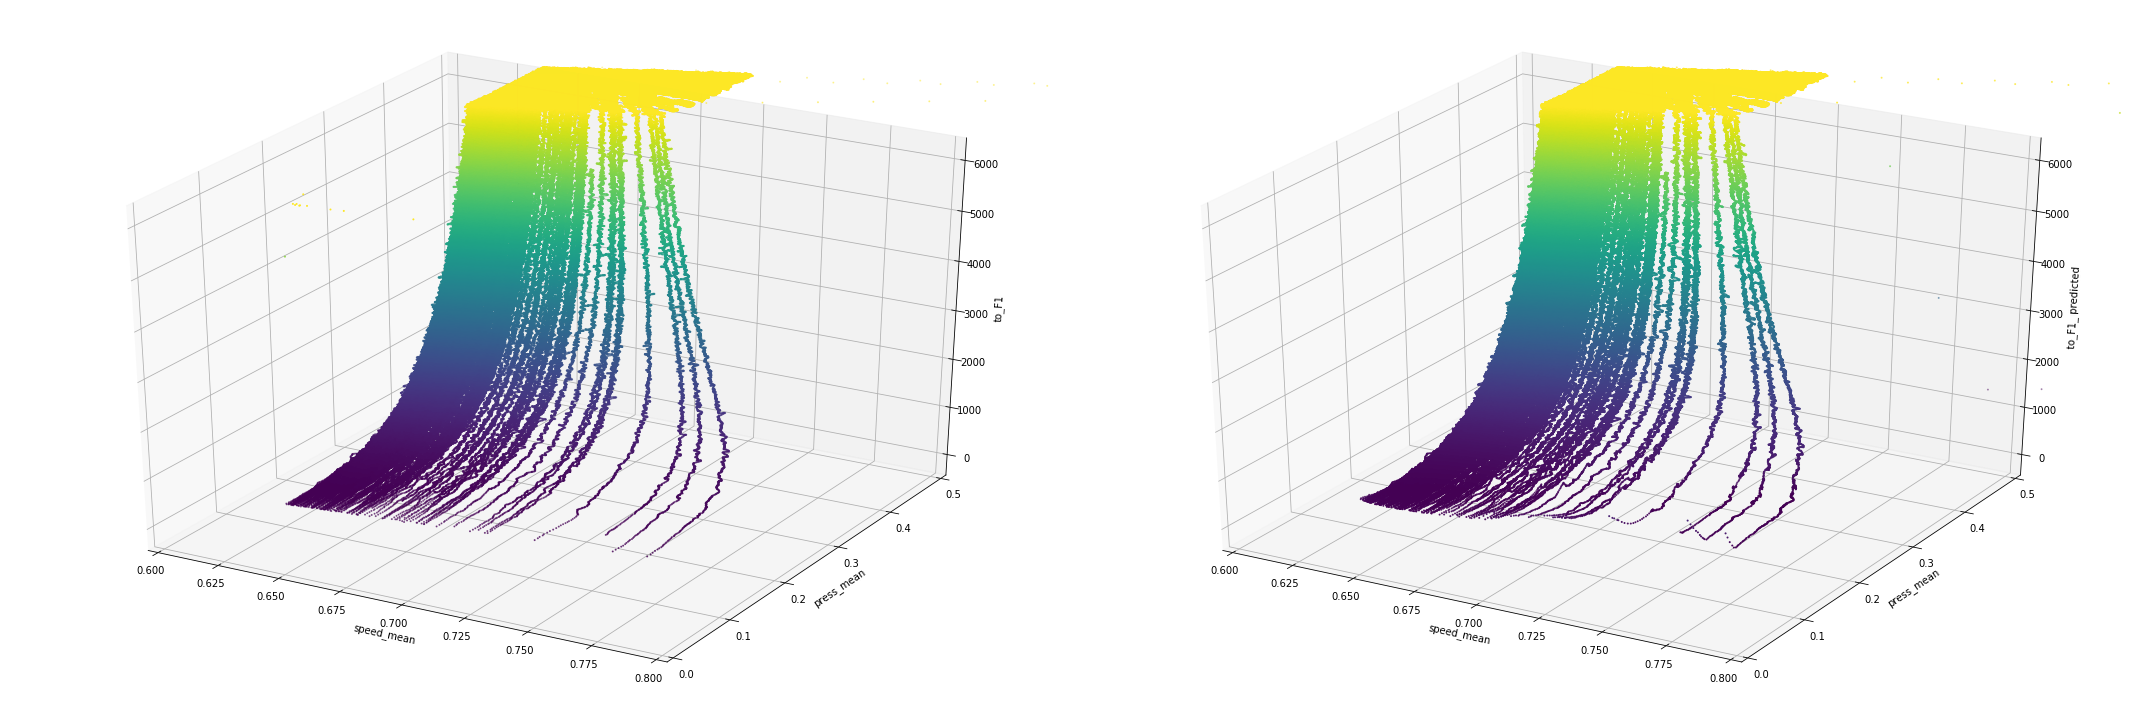

CPU times: user 3min 1s, sys: 2.86 s, total: 3min 4s
Wall time: 2min 58s


In [253]:
%%time
df = donnees_train_code[0]
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
z = df["to_F1"]
ax.scatter(xs=df["speed_mean"], ys=df["press_mean"], zs=z, s=1, c=z)
ax.set_xlim([.6, .8])
ax.set_ylim([0, .5])
ax.set_xlabel('speed_mean')
ax.set_ylabel('press_mean')
ax.set_zlabel('to_F1')

ax = fig.add_subplot(1, 2, 2, projection='3d')
z = np.clip(ridge1.predict(donnees_train_sans_poly), a_min=0, a_max=maxi)
ax.scatter(xs=df["speed_mean"], ys=df["press_mean"], zs=z, s=1, c=z)
ax.set_xlim([.6, .8])
ax.set_ylim([0, .5])
ax.set_xlabel('speed_mean')
ax.set_ylabel('press_mean')
ax.set_zlabel('to_F1_ predicted')
plt.tight_layout()
plt.show()

In [56]:
# Validation croisée: on ne peut utiliser directement
# # cross_val_score(ridge1, donnees_train_sans_poly, donnees_train_target[0], scoring="neg_mean_squared_error", cv=5, n_jobs=-1, verbose=3)
# puisqu'on "clippe" les prédictions, donc il faut définir sa propre fonction de scoring.

## Régression polynomiale non régularisée

In [46]:
from sklearn.linear_model import LinearRegression

In [47]:
linreg1 = LinearRegression(normalize=True, n_jobs=-1)

In [48]:
%%time
linreg1.fit(donnees_train_sans_maxi_poly, donnees_train_target_maxi[0].values)

CPU times: user 35.2 s, sys: 6.85 s, total: 42 s
Wall time: 12 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

In [49]:
print("Erreur-type après adapation à l'ensemble d'entraînement: ",
      np.sqrt(mean_squared_error(donnees_train_target[0].values, np.clip(linreg1.predict(donnees_train_sans_poly), a_min=0, a_max=maxi))))

Erreur-type après adapation à l'ensemble d'entraînement:  17.341869640009982


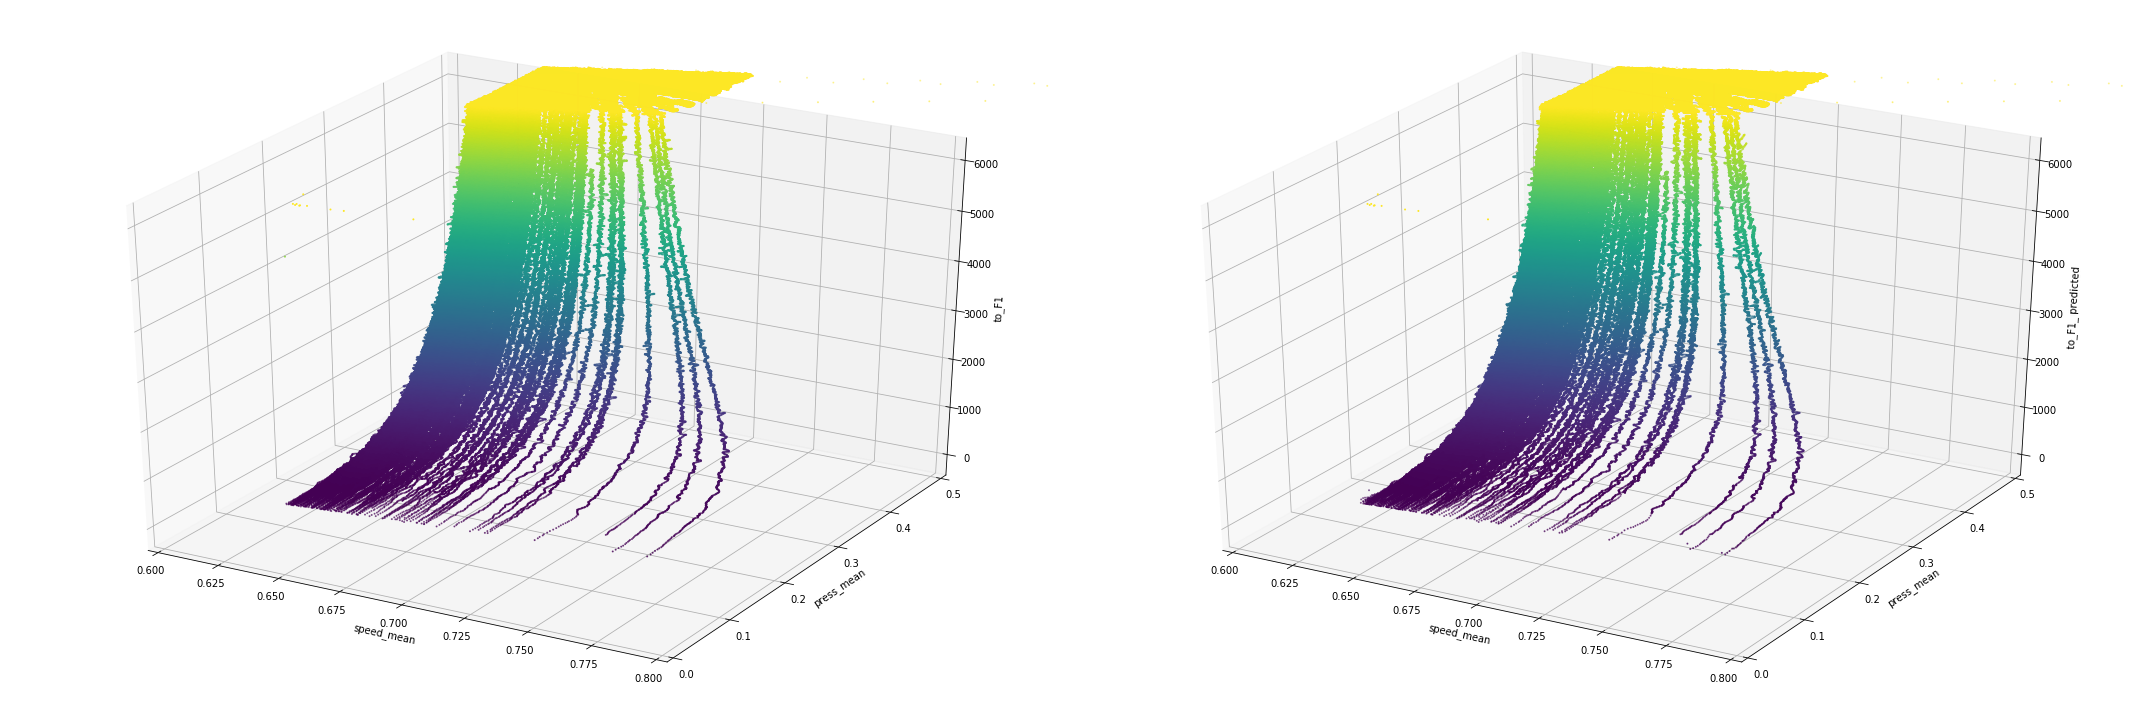

CPU times: user 2min 59s, sys: 3.18 s, total: 3min 2s
Wall time: 2min 56s


In [50]:
%%time
df = donnees_train_code[0]
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
z = df["to_F1"]
ax.scatter(xs=df["speed_mean"], ys=df["press_mean"], zs=z, s=1, c=z)
ax.set_xlim([.6, .8])
ax.set_ylim([0, .5])
ax.set_xlabel('speed_mean')
ax.set_ylabel('press_mean')
ax.set_zlabel('to_F1')

ax = fig.add_subplot(1, 2, 2, projection='3d')
z = np.clip(linreg1.predict(donnees_train_sans_poly), a_min=0, a_max=maxi)
ax.scatter(xs=df["speed_mean"], ys=df["press_mean"], zs=z, s=1, c=z)
ax.set_xlim([.6, .8])
ax.set_ylim([0, .5])
ax.set_xlabel('speed_mean')
ax.set_ylabel('press_mean')
ax.set_zlabel('to_F1_ predicted')
plt.tight_layout()
plt.show()

In [51]:
print("Erreur-type sur l'ensemble de test: ",
      np.sqrt(mean_squared_error(donnees_test_target[0].values, np.clip(linreg1.predict(donnees_test_sans_poly), a_min=0, a_max=maxi))))

Erreur-type sur l'ensemble de test:  20.946516224436213


## Arbre de décision
Remarque: ce type de modèle a tendance à suradapter, hors ici les données peuvent être bruitées, donc probablement pas le meilleur modèle.

In [53]:
from sklearn.tree import DecisionTreeRegressor

In [54]:
tree1 = DecisionTreeRegressor()

In [55]:
%%time
tree1_scores = cross_val_score(tree1, donnees_train_sans[0], donnees_train_target[0], scoring="neg_mean_squared_error", cv=9, n_jobs=-1, verbose=3)
tree1.fit(donnees_train_sans[0], donnees_train_target[0])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   15.5s remaining:   54.3s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   16.5s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   28.1s finished


CPU times: user 12.3 s, sys: 421 ms, total: 12.7 s
Wall time: 40.2 s


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [57]:
affiche_scores(np.sqrt(-tree1_scores))
print("Erreur-type après adapation à l'ensemble d'entraînement: ",
      np.sqrt(mean_squared_error(donnees_train_target[0], tree1.predict(donnees_train_sans[0]))))
print("Profondeur maximale de l'arbre: ", tree1.tree_.max_depth)

Validation croisée:
Moyenne:  17.607178132994395
Ecart-type:  0.5126565452506481
Erreur-type après adapation à l'ensemble d'entraînement:  0.0
Profondeur maximale de l'arbre:  52


On voit qu'il y a eu suradaptation (le score sur l'ensemble d'entraînement est bien meilleur que les scores sur les ensembles de validation). Essayons en contraignant le modèle avec `max_depth`.

In [58]:
tree2 = DecisionTreeRegressor(max_depth=10)

In [61]:
%%time
tree2_scores = cross_val_score(tree2, donnees_train_sans[0], donnees_train_target[0], scoring="neg_mean_squared_error", cv=10, n_jobs=-1, verbose=3)
tree2.fit(donnees_train_sans[0], donnees_train_target[0])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   13.9s remaining:   32.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   23.5s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   24.5s finished


CPU times: user 10.5 s, sys: 527 ms, total: 11 s
Wall time: 34.7 s


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [62]:
affiche_scores(np.sqrt(-tree2_scores))
print("Erreur-type après adapation à l'ensemble d'entraînement: ",
      np.sqrt(mean_squared_error(donnees_train_target[0], tree2.predict(donnees_train_sans[0]))))

Validation croisée:
Moyenne:  17.34126077026962
Ecart-type:  0.40619405605939335
Erreur-type après adapation à l'ensemble d'entraînement:  17.218127826042657


Pas ou peu de suradaptation (le score est meilleur sur l'ensemble d'entraînement mais reste à moins d'un écart-type du score moyen sur les ensembles de validation).

In [63]:
joblib.dump(tree2, "tree2.pkl")

['tree2.pkl']

## Forêt aléatoire

In [65]:
from sklearn.ensemble import RandomForestRegressor

In [66]:
%%time
forest1 = RandomForestRegressor(oob_score=True, verbose=3, n_estimators=10, n_jobs=-1)
forest1.fit(donnees_train_sans[0], donnees_train_target[0])
print("Erreur-type: ", np.sqrt(mean_squared_error(donnees_train_target[0], forest1.predict(donnees_train_sans[0]))))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.


building tree 1 of 10building tree 2 of 10
building tree 3 of 10
building tree 4 of 10

building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   11.2s remaining:   26.2s


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   20.6s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.5s finished
/home/benoit/Documents/_programmation/_python/sopra/sopraenv/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:    0.9s remaining:    2.2s


Erreur-type:  5.674345018837153
CPU times: user 1min 55s, sys: 507 ms, total: 1min 56s
Wall time: 27.2 s


[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:    1.7s remaining:    0.7s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.7s finished


In [67]:
%%time
forest1_mse_scores = cross_val_score(forest1, donnees_train_sans[0], donnees_train_target[0], scoring="neg_mean_squared_error", cv=10, n_jobs=-1, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  2.0min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.2min remaining:  1.4min


CPU times: user 381 ms, sys: 569 ms, total: 950 ms
Wall time: 3min 11s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.2min finished


In [68]:
forest1_rmse_scores = np.sqrt(-forest1_mse_scores)
#print(forest1_mse_scores)
print("Erreur-type moyenne: ", forest1_rmse_scores.mean())
print("Ecart-type de l'erreur-type: ", forest1_rmse_scores.std())

Erreur-type moyenne:  13.48534484612685
Ecart-type de l'erreur-type:  0.5282852553771574


In [69]:
joblib.dump(forest1, "forest1.pkl")

['forest1.pkl']

Il y eu suradaptation. Contraignons la forêt, en cherchant de bons hyperparamètres par une validation croisée par recherche en grille.

In [70]:
from sklearn.model_selection import GridSearchCV

In [71]:
forest2 = RandomForestRegressor(oob_score=True, verbose=3)
param_grid = [{"n_estimators": [3, 10, 30], "max_depth": [7, 14, 21]}]
grid_search = GridSearchCV(forest2, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True, refit=True, verbose=3, n_jobs=-1)

In [72]:
%%time
grid_search.fit(donnees_train_sans[0], donnees_train_target[0])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 16.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 30


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


building tree 2 of 30


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.6s remaining:    0.0s


building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.0min finished


CPU times: user 4min 6s, sys: 1.54 s, total: 4min 8s
Wall time: 20min 39s


/home/benoit/Documents/_programmation/_python/sopra/sopraenv/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=True, random_state=None,
                                             verbose=3, warm_start=False),
             iid='deprecated', n_job

In [73]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), "  ", params)
print("Meilleurs paramètres: ", grid_search.best_params_) # résultat: {'max_depth': 21, 'n_estimators': 30}

18.95160933027096    {'max_depth': 7, 'n_estimators': 3}
18.84849136210522    {'max_depth': 7, 'n_estimators': 10}
18.782953343872833    {'max_depth': 7, 'n_estimators': 30}
15.505477848339662    {'max_depth': 14, 'n_estimators': 3}
15.260636491273075    {'max_depth': 14, 'n_estimators': 10}
15.150195229167586    {'max_depth': 14, 'n_estimators': 30}
14.711347530750992    {'max_depth': 21, 'n_estimators': 3}
13.668520724049502    {'max_depth': 21, 'n_estimators': 10}
13.391823655444078    {'max_depth': 21, 'n_estimators': 30}
Meilleurs paramètres:  {'max_depth': 21, 'n_estimators': 30}


In [74]:
print("Erreur-type: ", np.sqrt(mean_squared_error(donnees_test_target[0], grid_search.predict(donnees_test_sans[0]))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Erreur-type:  23.052519878067866


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.8s finished


In [75]:
joblib.dump(grid_search, "forest2_grid_search.pkl")

['forest2_grid_search.pkl']

Intervalle de confiance pour l'erreur de généralisation

In [77]:
confidence = .95
squared_errors = (grid_search.predict(donnees_test_sans[0]) - donnees_test_target[0]) ** 2
print("*** Intervalle de confiance à 95% pour l'erreur-type pour les pannes F1: ",
      np.sqrt(stats.t.interval(confidence, len(squared_errors) -1, loc = squared_errors.mean(), scale = stats.sem(squared_errors))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


*** Intervalle de confiance à 95% pour l'erreur-type pour les pannes F2:  [21.20761017 24.76034363]


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.8s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.8s finished


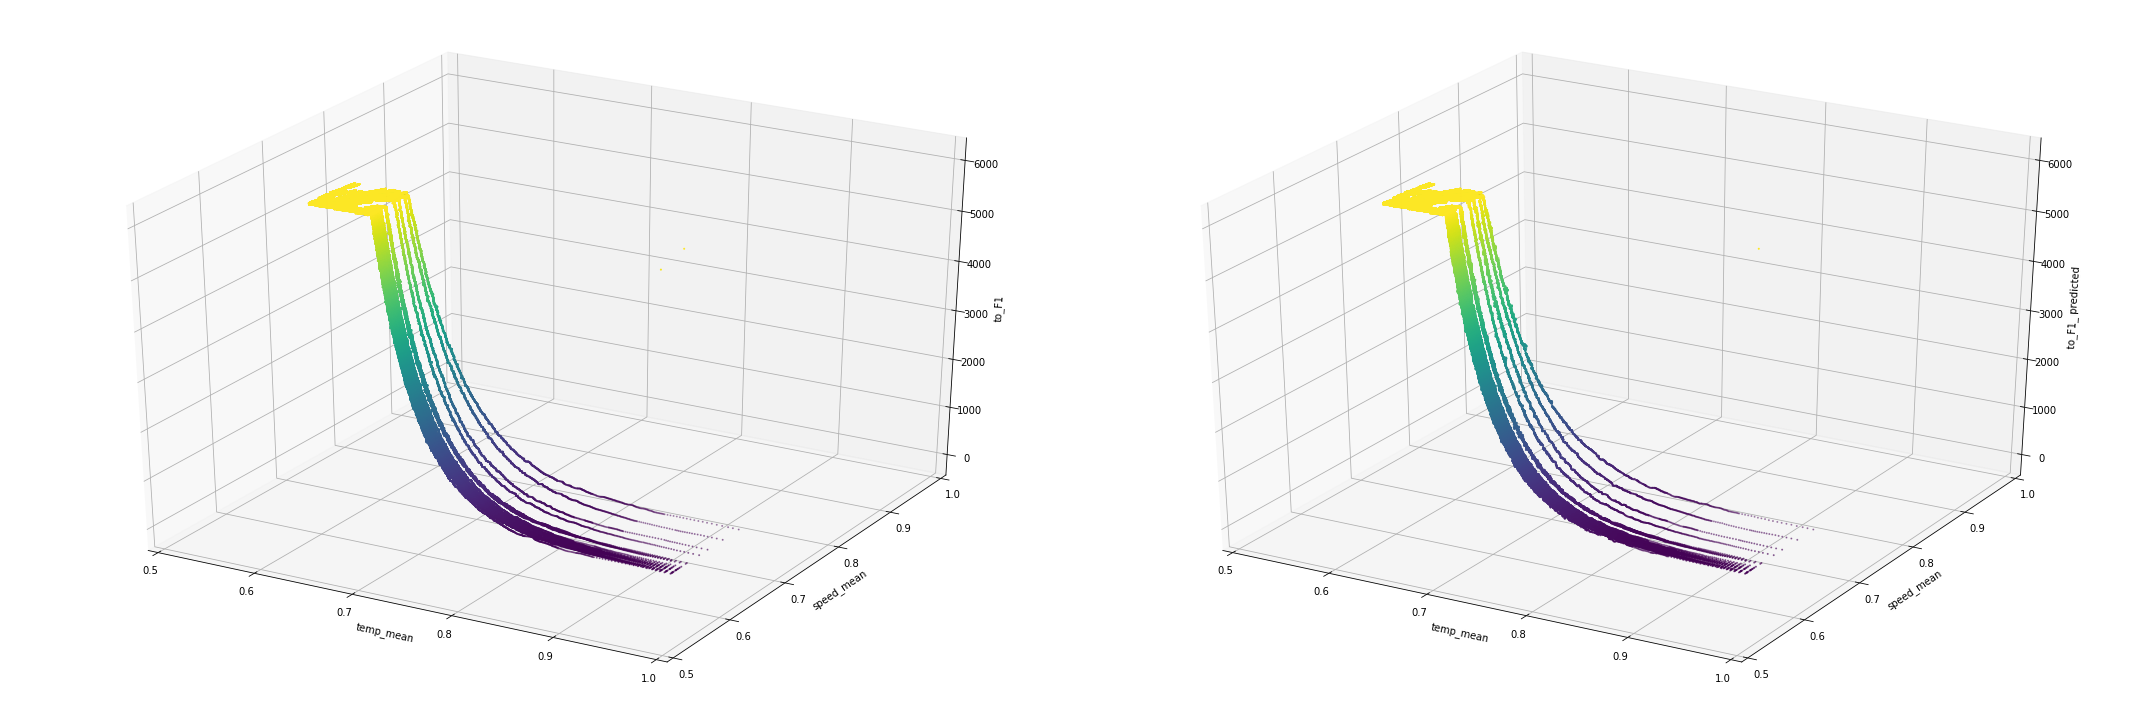

CPU times: user 32.3 s, sys: 1.75 s, total: 34 s
Wall time: 31.5 s


In [78]:
%%time
# Comparaison des prévisions pour les pannes F1.
# On ne représente que donnees_test pour des raisons de temps de calcul
df = donnees_test_code[0]
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
z = df["to_F1"]
ax.scatter(xs=df["temp_mean"], ys=df["speed_mean"], zs=z, s=1, c=z)
ax.set_xlim([.5, 1])
ax.set_ylim([.5, 1])
ax.set_xlabel('temp_mean')
ax.set_ylabel('speed_mean')
ax.set_zlabel('to_F1')

ax = fig.add_subplot(1, 2, 2, projection='3d')
z = grid_search.predict(donnees_test_sans[0])
ax.scatter(xs=df["temp_mean"], ys=df["speed_mean"], zs=z, s=1, c=z)
ax.set_xlim([.5, 1])
ax.set_ylim([.5, 1])
ax.set_xlabel('temp_mean')
ax.set_ylabel('speed_mean')
ax.set_zlabel('to_F1_ predicted')
plt.tight_layout()
plt.show()

 ### Pannes de code F2

In [79]:
forest2_F2 = RandomForestRegressor(oob_score=True, verbose=3)

In [80]:
param_grid_F2 = [{"n_estimators": [10, 30, 50], "max_depth": [5, 7, 14]}]

In [81]:
grid_search_F2 = GridSearchCV(forest2_F2, param_grid_F2, cv=5, scoring="neg_mean_squared_error", return_train_score=True, refit=True, verbose=3, n_jobs=-1)

In [82]:
%%time
grid_search_F2.fit(donnees_train_sans[1], donnees_train_target[1])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 22.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 30


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


building tree 2 of 30


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s


building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.5min finished


CPU times: user 2min 34s, sys: 1.76 s, total: 2min 36s
Wall time: 25min 9s


/home/benoit/Documents/_programmation/_python/sopra/sopraenv/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=True, random_state=None,
                                             verbose=3, warm_start=False),
             iid='deprecated', n_job

In [83]:
cvres_F2 = grid_search_F2.cv_results_
for mean_score, params in zip(cvres_F2["mean_test_score"], cvres_F2["params"]):
    print(np.sqrt(-mean_score), "  ", params)
print("Meilleurs paramètres: ", grid_search_F2.best_params_) # résultat: {'max_depth': 14, 'n_estimators': 30}

27.661347920434686    {'max_depth': 5, 'n_estimators': 10}
27.50979727096278    {'max_depth': 5, 'n_estimators': 30}
27.544101055231618    {'max_depth': 5, 'n_estimators': 50}
19.99122420057057    {'max_depth': 7, 'n_estimators': 10}
19.83774449442506    {'max_depth': 7, 'n_estimators': 30}
19.9212018748797    {'max_depth': 7, 'n_estimators': 50}
15.827109718385145    {'max_depth': 14, 'n_estimators': 10}
15.69059169556605    {'max_depth': 14, 'n_estimators': 30}
15.728778827323545    {'max_depth': 14, 'n_estimators': 50}
Meilleurs paramètres:  {'max_depth': 14, 'n_estimators': 30}


In [84]:
print("*** Erreur-type sur l'ensemble de test pour les pannes F2: ",
      np.sqrt(mean_squared_error(donnees_test_target[1], grid_search_F2.predict(donnees_test_sans[1]))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


*** Erreur-type sur l'ensemble de test pour les pannes F2:  18.991821155494865


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished


In [85]:
joblib.dump(grid_search_F2, "forest2_F2_grid_search.pkl")

['forest2_F2_grid_search.pkl']

In [86]:
confidence = .95
squared_errors = (grid_search_F2.predict(donnees_test_sans[1]) - donnees_test_target[1]) ** 2
print("*** Intervalle de confiance à 95% pour l'erreur-type pour les pannes F2: ",
      np.sqrt(stats.t.interval(confidence, len(squared_errors) -1, loc = squared_errors.mean(), scale = stats.sem(squared_errors))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


*** Intervalle de confiance à 95% pour l'erreur-type pour les pannes F2:  [18.83131279 19.15098432]


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished


## Réseau de neurones (MLP)

In [87]:
from sklearn.neural_network import MLPRegressor

In [88]:
mlp1 = MLPRegressor(hidden_layer_sizes=(30, 30), activation="relu", verbose=3, early_stopping=True, n_iter_no_change=5, tol=1e-5)

In [89]:
%%time
mlp1.fit(donnees_train_sans[0], donnees_train_target[0])
print("Erreur-type: ", np.sqrt(mean_squared_error(donnees_train_target[0], mlp1.predict(donnees_train_sans[0]))))

Iteration 1, loss = 733968.44024594
Validation score: 0.906617
Iteration 2, loss = 22289.25566035
Validation score: 0.992097
Iteration 3, loss = 4411.51591898
Validation score: 0.998090
Iteration 4, loss = 1114.19737347
Validation score: 0.999248
Iteration 5, loss = 660.87572133
Validation score: 0.999366
Iteration 6, loss = 584.60383777
Validation score: 0.999424
Iteration 7, loss = 543.60750172
Validation score: 0.999449
Iteration 8, loss = 514.36309972
Validation score: 0.999480
Iteration 9, loss = 492.60429372
Validation score: 0.999510
Iteration 10, loss = 474.93979675
Validation score: 0.999503
Iteration 11, loss = 461.00425815
Validation score: 0.999512
Iteration 12, loss = 449.99586106
Validation score: 0.999527
Iteration 13, loss = 440.88868666
Validation score: 0.999543
Iteration 14, loss = 432.57794374
Validation score: 0.999553
Iteration 15, loss = 425.32694406
Validation score: 0.999574
Iteration 16, loss = 418.82076223
Validation score: 0.999581
Iteration 17, loss = 413.1

In [92]:
joblib.dump(mlp1, "mlp1.pkl")

['mlp1.pkl']

In [93]:
print("Erreur-type après adapation à l'ensemble d'entraînement: ",
      np.sqrt(mean_squared_error(donnees_train_target[0], mlp1.predict(donnees_train_sans[0]))))

Erreur-type après adapation à l'ensemble d'entraînement:  26.832120225118118


## Réseau de neurones (MLP) --- (en cours)

In [ ]:
# Mélange des données d'entraînement:
donnees_train = donnees_train.sample(frac=1).reset_index(drop=True)

In [ ]:
# création d'un ensemble de validation
# le nouvel ensemble d'entraînemt est réduit, donc se nomme "tra" au lieu de "train"
donnees_tra, donnees_valid = split_train_test(donnees_train, mac_panne, test_ratio=0.15, seed=10)

In [ ]:
donnees_tra_code = donnees_par_code(donnees_tra)
donnees_valid_code = donnees_par_code(donnees_valid)

In [ ]:
donnees_tra_sans, donnees_tra_target = separe_target(donnees_tra_code)
donnees_valid_sans, donnees_valid_target = separe_target(donnees_valid_code)

In [ ]:
mlp = keras.models.Sequential([
    keras.layers.Dense(10, input_dim=3, activation="elu", kernel_initializer="he_normal"),
#    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="elu", kernel_initializer="he_normal"),
#    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="relu"),
])

In [ ]:
mlp.summary()

In [ ]:
mlp.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True, clipvalue=1))

In [ ]:
%%time
# Pour la panne F1
history_F1 = mlp.fit(donnees_tra_sans[0][:100_000].values, donnees_tra_target[0][:100_000].values, epochs=3, batch_size=32, validation_data=(donnees_valid_sans[0].values, donnees_valid_target[0].values))

In [ ]:
pd.DataFrame(history_F1.history).plot(figsize=(10,8))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
%%time
# Pour la panne F2
history_F2 = mlp.fit(donnees_tra_sans[1].values, donnees_tra_target[1].values, epochs=3, batch_size=32, validation_data=(donnees_valid_sans[1].values, donnees_valid_target[1].values))

In [ ]:
mlp.layers

In [ ]:
mlp.layers[0].get_weights()

In [ ]:
mlp.layers[0].get_weights()[0].shape

In [ ]:
mlp.layers[0].get_weights()[1].shape